In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import fastai
import fastai.dataset
import pydicom
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai.conv_learner import *
from fastai.dataset import *


In [57]:
torch.backends.cudnn.benchmark=True

In [58]:
PATH = Path('path/to/data')

In [59]:
def isdicom(fn):
    if fn.endswith('.dcm'):
        return True
    with open(fn) as fh:
        fh.seek(0x80)
        return fh.read(4)=='DICM'


def open_image(fn):
    """ Modifying fastai's open_image to allow dicom files to be read.
    from https://www.kaggle.com/dovgro/fastai-exploration

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    elif isdicom(fn):
        slice = pydicom.read_file(fn)
        if slice.PhotometricInterpretation.startswith('MONOCHROME'):
            # Make a fake RGB image
            im = np.stack([slice.pixel_array]*3,-1)
            return im / ((1 << slice.BitsStored)-1)
        else:
            raise OSError('Unsupported DICOM image with PhotometricInterpretation=={}'.format(slice.PhotometricInterpretation))
    else:
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

fastai.dataset.isdicom=isdicom
fastai.dataset.pydicom=pydicom
fastai.dataset.open_image=open_image

In [80]:
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])
def bb_hw(a):return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])


def parse_data(df):
    parsed = collections.defaultdict(lambda:{'dicom': None,    
        'label': None})
    for n, row in df.iterrows():
        pid = row['patientId']
        parsed[pid]['dicom'] = str(f'{pid}.dcm')
        parsed[pid]['label'] = row['Target']
    return parsed


def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(16,8), ax =ax)
    l = ann['label']
        
        
def draw_idx(i, ax=None):
    im_a = parsed_lrg[i]
    im = open_image('path/to/training/images'+parsed[i]['dicom'])
    draw_im(im, im_a, ax=ax)

In [70]:
label_csv = PATH/'stage_2_train_labels.csv'
df = pd.read_csv(label_csv)
label_df = df.filter(['patientId', 'Target'], )
label_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [71]:
parsed = parse_data(label_df)
len(parsed)

26684

In [72]:
parsed["00436515-870c-4b36-a041-de91049b9ab4"]

{'dicom': '00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1}

In [73]:
cats = {'0': 'normal', '1': 'pneumonia'}

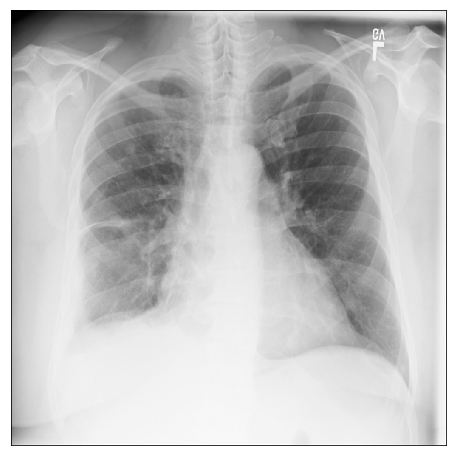

In [81]:
patient = df.patientId.sample().values[0]
draw_idx(patient)

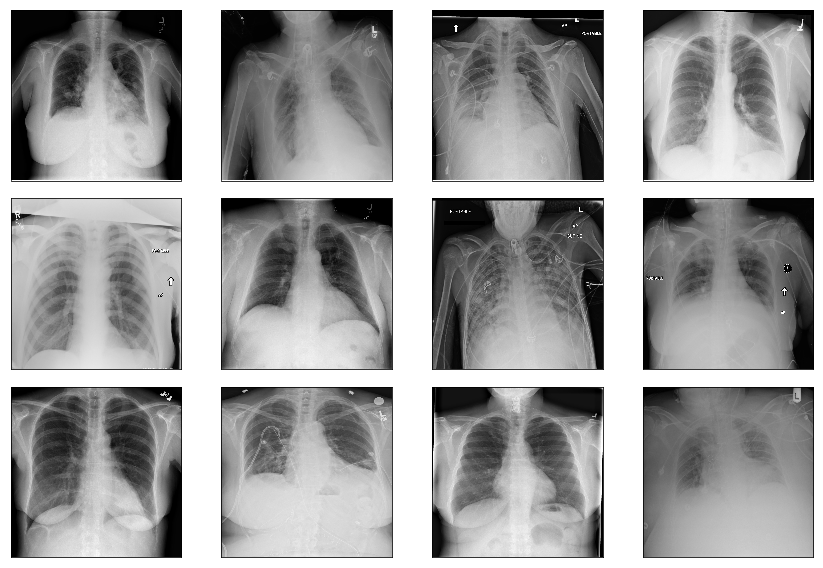

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    patient = df.patientId.sample().values[0]
    draw_idx(patient, ax=ax)

plt.tight_layout()

In [44]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [47]:
df = pd.DataFrame({'fn': [parsed[o]['dicom'] for o in parsed],
                   'cat': [parsed[o]['label'] for o in parsed]})

In [48]:
df[['fn', 'cat']].to_csv(CSV, index=False)

In [50]:
df.head()

,fn,cat
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,1


In [49]:
f_model = resnet34
sz=224
bs=64

In [51]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, 'stage_2_train_images', CSV, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [52]:
x,y=next(iter(md.val_dl))

In [53]:
y[0]

0

### Training

 66%|██████▌   | 219/334 [08:10<07:02,  3.68s/it, loss=2.38]

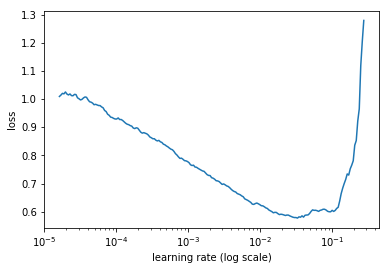

In [59]:
lrf = learn.lr_find(1e-5,100)
learn.sched.plot()

In [60]:
lr = 1e-2

In [61]:
learn.fit(lr,1,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.423541   0.406193   0.809408  


[array([0.40619]), 0.8094077961913113]

In [62]:
lrs = np.array([lr/1000,lr/100,lr])

In [63]:
learn.freeze_to(-2)

 73%|███████▎  | 244/334 [09:38<04:02,  2.69s/it, loss=1.87]

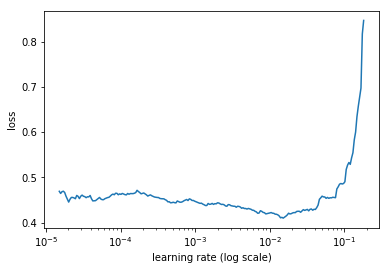

In [64]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot()

In [65]:
learn.fit(lr,1,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.362819   0.36201    0.836769  


[array([0.36201]), 0.8367691153529165]

In [66]:
learn.save('clas_one')

In [24]:
learn.load('clas_one')

In [41]:
x,y=next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model,x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds,-1)

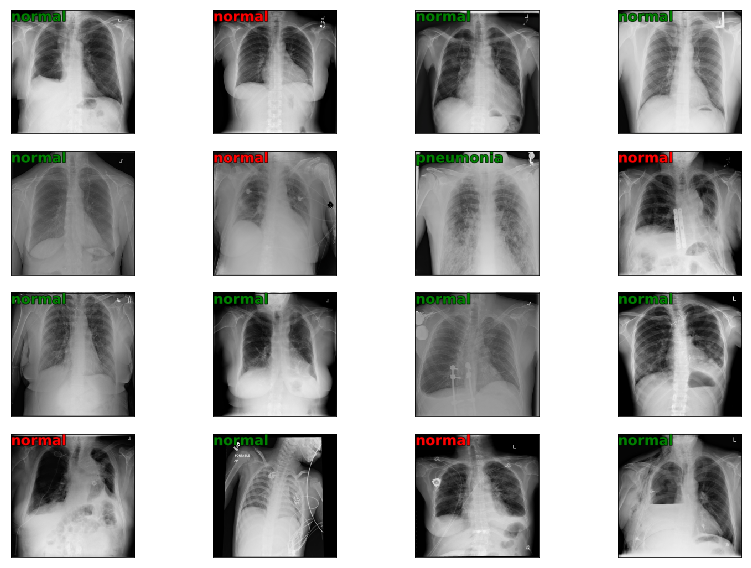

In [55]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b=md.classes[preds[i]]
    ax = show_img(ima,ax=ax)
    if int(b) == y[i]:
        draw_text(ax,(0,0),cats[b], col = 'green')
    else:
        draw_text(ax,(0,0),cats[b], col = 'red')

plt.tight_layout()

 62%|██████▏   | 206/334 [11:20<12:33,  5.88s/it, loss=1.68]

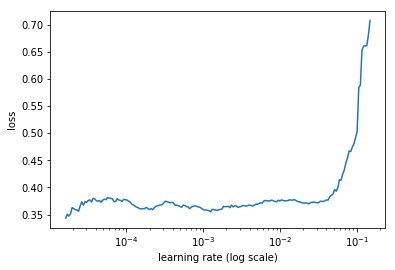

In [37]:
lrf=learn.lr_find(1e-5,100)
learn.sched.plot()

In [38]:
learn.unfreeze()


In [40]:
lr = 1e-4

In [41]:
lrs = np.array([lr/1000,lr/100,lr])

In [42]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.369961   0.367376   0.835832  
    1      0.369519   0.367863   0.833958  


[array([0.36786]), 0.8339580209001429]